# Advanced glider analysis

Some gliders have specialist sensors that are not easily integrated into the main datasets. One of these is the Nortek 1MHz ADCP. This notebook shows how to download ADCP data and integrate it with the main dataset

In [1]:
import matplotlib.pyplot as plt
import datetime
from matplotlib import style
style.use('presentation.mplstyle')
import utils
from erddapy import ERDDAP
import pandas as pd

### 1. Find a dataset with ADCP data

We fetch the table of all datasets and keep only those that whose ID starts with "adcp"



In [2]:
e = ERDDAP(
    server="https://erddap.observations.voiceoftheocean.org/erddap",
    protocol="tabledap",
)

# Fetch dataset list
e.response = "csv"
e.dataset_id = "allDatasets"
df_datasets = e.to_pandas(parse_dates=['minTime (UTC)', 'maxTime (UTC)'])

# drop the allDatasets row and make the datasetID the index for easier reading
df_datasets.set_index("datasetID", inplace=True)
df_datasets.drop("allDatasets", inplace=True)

In [3]:
df_datasets = df_datasets[df_datasets.index.str[:4] == "adcp"]
df_datasets.head()

,accessible,institution,dataStructure,cdm_data_type,class,title,minLongitude (degrees_east),maxLongitude (degrees_east),longitudeSpacing (degrees_east),minLatitude (degrees_north),...,fgdc,iso19115,metadata,sourceUrl,infoUrl,rss,email,testOutOfDate,outOfDate,summary
datasetID,,,,,,,,,,,,,,,,,,,,,
adcp_SEA045_M33,public,Voice of the Ocean Foundation,grid,Grid,EDDGridFromNcFiles,Kvanne45-20200820T0747_adcp,NaN,NaN,NaN,NaN,...,NaN,NaN,https://erddap.observations.voiceoftheocean.or...,(local files),https://observations.voiceoftheocean.org,https://erddap.observations.voiceoftheocean.or...,https://erddap.observations.voiceoftheocean.or...,NaN,NaN,Part of SAMBA continuous monitoring
adcp_SEA045_M37,public,Voice of the Ocean Foundation,grid,Grid,EDDGridFromNcFiles,Kvanne45-20210319T1415_adcp,NaN,NaN,NaN,NaN,...,NaN,NaN,https://erddap.observations.voiceoftheocean.or...,(local files),https://observations.voiceoftheocean.org,https://erddap.observations.voiceoftheocean.or...,https://erddap.observations.voiceoftheocean.or...,NaN,NaN,Part of SAMBA continuous monitoring
adcp_SEA045_M41,public,Voice of the Ocean Foundation,grid,Grid,EDDGridFromNcFiles,Kvanne45-20210413T1204_adcp,NaN,NaN,NaN,NaN,...,NaN,NaN,https://erddap.observations.voiceoftheocean.or...,(local files),https://observations.voiceoftheocean.org,https://erddap.observations.voiceoftheocean.or...,https://erddap.observations.voiceoftheocean.or...,NaN,NaN,Part of SAMBA continuous monitoring
adcp_SEA045_M42,public,Voice of the Ocean Foundation,grid,Grid,EDDGridFromNcFiles,Kvanne45-20210518T0809_adcp,NaN,NaN,NaN,NaN,...,NaN,NaN,https://erddap.observations.voiceoftheocean.or...,(local files),https://observations.voiceoftheocean.org,https://erddap.observations.voiceoftheocean.or...,https://erddap.observations.voiceoftheocean.or...,NaN,NaN,Part of SAMBA continuous monitoring
adcp_SEA045_M48,public,Voice of the Ocean Foundation,grid,Grid,EDDGridFromNcFiles,Kvanne45-20211004T1941_adcp,NaN,NaN,NaN,NaN,...,NaN,NaN,https://erddap.observations.voiceoftheocean.or...,(local files),https://observations.voiceoftheocean.org,https://erddap.observations.voiceoftheocean.or...,https://erddap.observations.voiceoftheocean.or...,NaN,NaN,Part of SAMBA continuous monitoring


### 2. Download ADCP data and combine it with glider data

Here we use a time constraint to download only the most recent few days to check the quality of the ADCP data without downloading the entire dataset

In [4]:
datasets_to_download = ['delayed_SEA063_M33', "nrt_SEA063_M33"]
ds_dict = utils.download_glider_dataset(datasets_to_download, nrt_only=False, adcp=True,
                                        constraints={"time>=": datetime.datetime(2022,1,20)})


  0%|          | 0/2 [00:00<?, ?it/s]

Found delayed_SEA063_M33 in voto_erddap_data_cache. Loading from disk
Found voto_erddap_data_cache/adcp_SEA063_M33.nc. Loading from disk
Found voto_erddap_data_cache/adcp_SEA063_M33.nc. Loading from disk


In [5]:
ds = ds_dict['delayed_SEA063_M33']
nrt = ds_dict['nrt_SEA063_M33']

### 3. Examine the datasets

We see that adding ADCP with the kwarg `adcp=True` has added two additional dimenstions to our dataset: cell and beam. These are from the 4 beams and 30 sampling cells of the ADCP

In [6]:
nrt

<xarray.Dataset>
Dimensions:                        (time: 1410, cell: 30, beam: 4)
Coordinates:
    latitude                       (time) float64 ...
    longitude                      (time) float64 ...
  * time                           (time) datetime64[ns] 2022-01-20T00:54:39....
    depth                          (time) float64 ...
  * cell                           (cell) int16 0 1 2 3 4 5 ... 25 26 27 28 29
  * beam                           (beam) int16 0 1 2 3
Data variables: (12/55)
    ad2cp_beam1_cell_number1       (time) float32 ...
    ad2cp_beam2_cell_number1       (time) float32 ...
    ad2cp_beam3_cell_number1       (time) float32 ...
    ad2cp_beam4_cell_number1       (time) float32 ...
    ad2cp_heading                  (time) float32 ...
    ad2cp_pitch                    (time) float32 ...
    ...                             ...
    turbidity_raw                  (time) float32 ...
    vertical_distance_to_seafloor  (time) float32 ...
    voltage                        (time) float32 ...
    adcp_correlation               (time, cell, beam) float32 ...
    adcp_amplitude                 (time, cell, beam) float32 ...
    adcp_velocity                  (time, cell, beam) float32 ...
Attributes: (12/78)
    acknowledgement:               This study used data collected and made fr...
    AD2CP:                         {'calibration_date': '2021-02-03', 'factor...
    altimeter:                     {'make': 'UNKNOWN', 'model': 'UNKNOWN', 's...
    basin:                         Bornholm Basin
    cdm_data_type:                 TimeSeries
    cdm_timeseries_variables:      profile_index
    ...                            ...
    total_dives:                   132.0
    transmission_system:           IRIDIUM
    variables:                     time\nlatitude\nlongitude\nnav_state\nhead...
    Westernmost_Easting:           16.041083333333333
    wmo_id:                        6801707
    adcp_attributes:               {'alternateEnable': 0, 'alternateEnable_de...

We have 20 or so dives in the nrt data. A nice size dataset to inspect

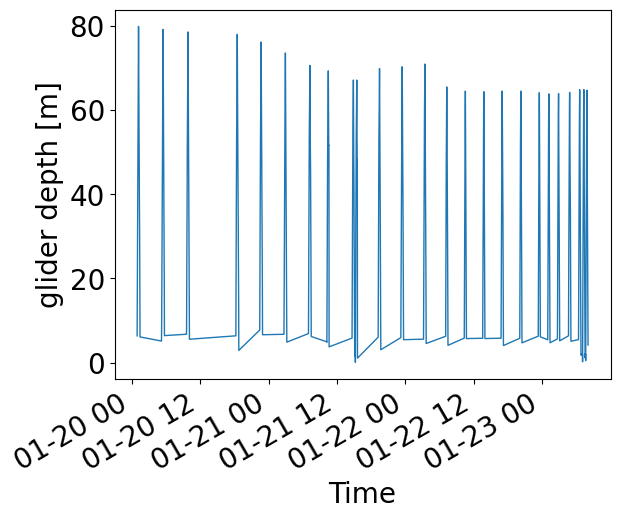

In [7]:
nrt.depth.plot()

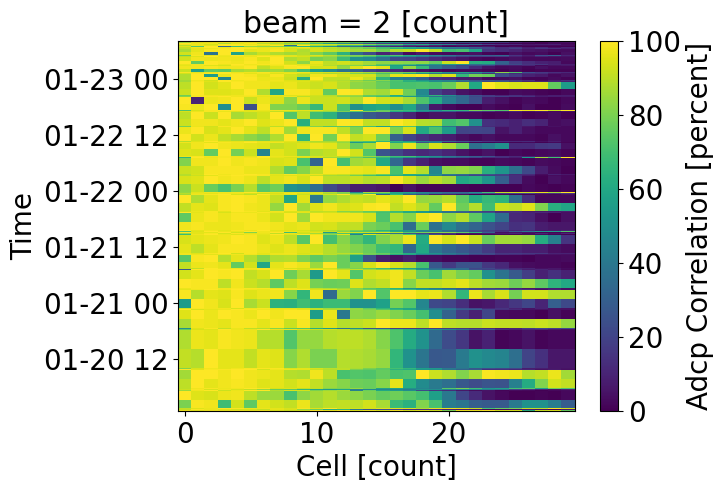

In [8]:
nrt.adcp_correlation[:,:,2].plot()

We can see how beam correlation decreases with increasing distance from the glider